# Purpose of this simulation


In [3]:
import numpy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tables
import aopy

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('talk')

# ideas

In [4]:
# this is for creating exp_conditions that scan the difference across the files
#for comparision
#data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/'
# data_dump_folder = \
# 'D:/sim_data/gaussian_peaks/2022_02_02_gaussian_peaks/'

data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/convex_selection/logical_or/'

random_seed = 0
n_neurons = 128
# 
mean_first_peak = 50
mean_second_peak = 50
std = 10

# clda setup 
rho = 0.5
batchlen = 100

# noises = np.arange(9)
# noises = np.exp2(noises)
noises = [32]

exp_conds = []
for mean_second_peak in [100]:
    for noise in noises:
        exp_conds_wo = [f'wo_FS_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]
        exp_conds_add = [f'iter_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]
        exp_conds_keep = [f'same_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]

        # we add to the exp list
        exp_conds.extend(exp_conds_wo)
        exp_conds.extend(exp_conds_add)
        exp_conds.extend(exp_conds_keep)

feature_selection_schemes = ['w/o feature selection', 'iter', 'subset throughout']

print("the folder at which data is located:")
print(data_dump_folder)
print(exp_conds)

the folder at which data is located:
/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/convex_selection/logical_or/
['wo_FS_1.0_0_noise_32_128_100_10_clda_rho_0.5_batchlen_100', 'iter_1.0_0_noise_32_128_100_10_clda_rho_0.5_batchlen_100', 'same_1.0_0_noise_32_128_100_10_clda_rho_0.5_batchlen_100']


# Preproc the feature files

In [5]:

from afs_files import load_feature_selection_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

we collected 3 number of experiments


In [6]:
no_noise_neuron_ind = exp_data_all[0]['feature_selection']['no_noise_neuron_ind']
noise_neuron_ind = exp_data_all[0]['feature_selection']['noise_neuron_ind']


# Check feature selection strategies

## check between conditions

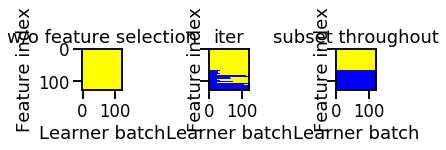

In [5]:
import importlib 
from afs_plotting import plot_feature_selection


fig_feat_activity, ax_feat_activity = plt.subplots(1, 3, 
                                                   sharey = True)



for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity)):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    
    #only title the exp if there are three exp, right. 
    if len(exp_data_all) == 3: 
        a.set_title(feature_selection_schemes[i])

fig_feat_activity.tight_layout()

In [6]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())


num_features_exp_by_batch = np.array(num_features_exp_by_batch)

In [135]:
num_features_exp_by_batch

array([[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128],
       [ 68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  69,  70,  70,  73,
         76,  78,  79,  79,  80,  80,  81,  82,  86,  86,  88,  89,  89,
         89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
         89,  89,

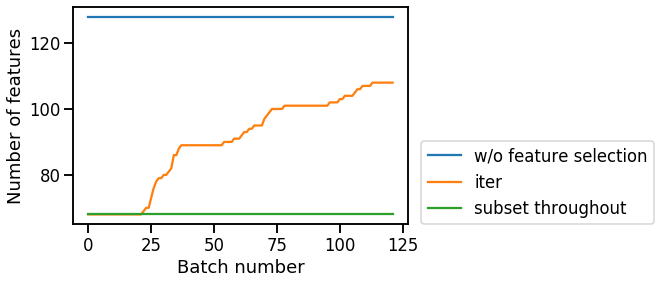

In [7]:
fig_num_features, ax_num_features = plt.subplots()

ax_num_features.plot(num_features_exp_by_batch.T)

ax_num_features.set_xlabel('Batch number')
ax_num_features.set_ylabel('Number of features')
ax_num_features.legend(feature_selection_schemes, loc=(1.04,0))


# Behaviour comparision

## count how many rewards

In [137]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((3,-1))
window_stamps_all = window_stamps_all.reshape((3,-1))

In [138]:
reward_rate_all
window_stamps_all

array([[  60.,   90.,  120.,  150.,  180.,  210.,  240.,  270.,  300.,
         330.,  360.,  390.,  420.,  450.,  480.,  510.,  540.,  570.,
         600.,  630.,  660.,  690.,  720.,  750.,  780.,  810.,  840.,
         870.,  900.,  930.,  960.,  990., 1020., 1050., 1080., 1110.],
       [  60.,   90.,  120.,  150.,  180.,  210.,  240.,  270.,  300.,
         330.,  360.,  390.,  420.,  450.,  480.,  510.,  540.,  570.,
         600.,  630.,  660.,  690.,  720.,  750.,  780.,  810.,  840.,
         870.,  900.,  930.,  960.,  990., 1020., 1050., 1080., 1110.],
       [  60.,   90.,  120.,  150.,  180.,  210.,  240.,  270.,  300.,
         330.,  360.,  390.,  420.,  450.,  480.,  510.,  540.,  570.,
         600.,  630.,  660.,  690.,  720.,  750.,  780.,  810.,  840.,
         870.,  900.,  930.,  960.,  990., 1020., 1050., 1080., 1110.]])

Text(0, 0.5, 'Reward rate ')

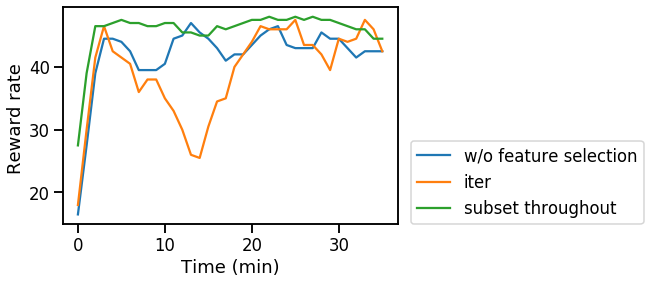

In [139]:
colors = ['blue', 'orange', 'red']

plt.plot(reward_rate_all.T)
plt.legend(feature_selection_schemes, loc=(1.04,0))
plt.xlabel('Time (min)')
plt.ylabel('Reward rate ')


## Trial segments and trajectories

In [9]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

import functools

def get_all_cursor_trajectories(exp_data_all, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    cursor_trajectories_list = list()
        
    for e in exp_data_all:
        (cursor_trajectories, trial_segments, trial_times) = get_cursor_trajectories_from_parsed_data(e, start_code = start_code, end_codes=end_codes)
        cursor_trajectories_list.append(cursor_trajectories)

    
    return cursor_trajectories_list

def get_cursor_trajectories_from_parsed_data(exp_data, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    
    events = exp_data['events']
    cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle

    streamed_code = events['code']
    event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

    trial_segments, trial_times = aopy.preproc.get_trial_segments(streamed_code, event_cycles, start_code,  end_codes)
    trial_segments = np.array(trial_segments)
    trial_indices = [range(t[0], t[1]) for t in trial_times]
    cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
    
    return (cursor_trajectories, trial_segments, trial_times)

In [10]:
start_codes = range(17, 24)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)


range(17, 24)


In [11]:
def calc_trial_times(trial_times):
    """
    for each row, calculate the difference between the last and first elements
    """
    row_index = 1 
    
    return np.apply_along_axis(lambda row: row[-1] - row[0], row_index, trial_times)


#calc_trial_times(trial_times)

In [12]:
# get the unique target positions

from typing import List, Dict
import seaborn as sns


def plot_cursor_trajectories(cursor_trajectories: List, exp_data:Dict, exp_metadata,ax = None):

    fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)


    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    
    sns.color_palette("dark:salmon_r", as_cmap=True)

    aopy.visualization.plot_trajectories(cursor_trajectories, bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, ax = ax)

IndexError: too many indices for array

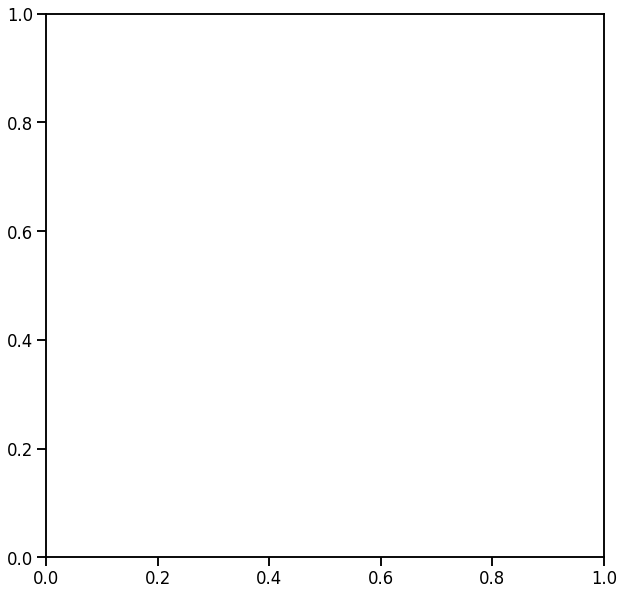

In [13]:
cursor_trajectories_list = np.array(cursor_trajectories_list).reshape(3, -1)



for c in cursor_trajectories_list[:,2]:
    plot_cursor_trajectories(c[:10], exp_data_all[0], exp_metadata_all[0])

# Post data analysis

In [8]:
feature_selection = exp_data_all[0]["feature_selection"]
feature_selection.keys()

C_mat = feature_selection["C_mat"]
Q_diag_feature = feature_selection["Q_diag"]

print(C_mat.shape)

(121, 128, 7)


In [9]:
X_VEL_IND, Y_VEL_IND = 3,5
N_TOTAL_AVAIL_FEATS = 128

num_batches, num_sensors, num_states = C_mat.shape
offset = 1

start_of_feature_selection = 10

P = np.identity(num_sensors)

opt_values = []

for batch_i in range(num_batches):

    
    
    C_batch = C_mat[batch_i, :,(X_VEL_IND, Y_VEL_IND)].T
    Q_diag_values = Q_diag_feature[batch_i, :]
    
    Q_diag_matrix = np.diag(Q_diag_values)
    


        # save the optimal value batches
    Q_diag_inverse = np.linalg.inv(Q_diag_matrix)
    opt_values.append(np.log(np.linalg.det((C_batch.T @ Q_diag_inverse @ C_batch))))

opt_values = np.array(opt_values)

Text(0.5, 1.0, 'We want the optimal value to be high')

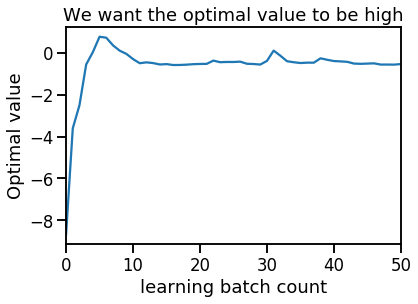

In [149]:
plt.plot(opt_values)
plt.xlim([0, 50])
plt.xlabel("learning batch count")
plt.ylabel("Optimal value")
plt.title("We want the optimal value to be high")

In [17]:
import cvxpy as cp
def convex_feature_selection_by_obj_fraction(C, Q_diag, optimal_val, offset):
    """
    trying to solve the convex feature selection problem of the form
    minimize f(z) = log det (C.T Q^(-1) diag(z) C )
    subject to 0.001 <= theta <= 1

    Args:
        C (np.array): num_features by num_states
        Q (np.array): 

    """

    if offset == 0:
        return np.ones((C.shape[0]))

    d = C.shape[0]
    ones_d = np.ones((d,1))
    theta = cp.Variable((d,1))

    Q_diag_inv =  np.linalg.inv(Q_diag)

    constraints = [theta >=0.0,  theta <= 1, 
                cp.log_det(C.T @ Q_diag_inv @cp.diag(theta) @ C) >= optimal_val - offset]

    feature_selection_objective = cp.Minimize( theta.T @ ones_d)
    feature_selection_problem = cp.Problem(feature_selection_objective, constraints)

    result = feature_selection_problem.solve()

    selected_values = theta.value.copy()

    return np.squeeze(selected_values), result



In [27]:
X_VEL_IND, Y_VEL_IND = 3,5
N_TOTAL_AVAIL_FEATS = 128

num_batches, num_sensors, num_states = C_mat.shape
offset = 1

selected_batches_throughout = []
selected_indices_throughout = []
result_all = []

selection_threshold = 0.5

active_feature_set = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)

active_feature_set_log = []

start_of_feature_selection = 10

P = np.identity(num_sensors)

for batch_i in range(num_batches):
    
    if batch_i < start_of_feature_selection:
        continue
    
    
    C_batch = C_mat[batch_i, :,(X_VEL_IND, Y_VEL_IND)].T
    Q_diag_values = Q_diag_feature[batch_i, :]
    
    Q_diag_matrix = np.diag(Q_diag_values)
    
    if batch_i  == start_of_feature_selection:
        Q_diag_inverse = np.linalg.inv(Q_diag_matrix)
        print(C_batch.shape)
        optimal_value_batches = np.log(np.linalg.det((C_batch.T @ Q_diag_inverse @ C_batch)))
        p_level = 0
    else:
        p_level = 0.0
        
        
    selected_values, result = convex_feature_selection_by_obj_fraction(C_batch, 
                                                                      Q_diag_matrix, 
                                                                      optimal_value_batches, 
                                                                      offset)
    
    
    
    
    selected_batches_throughout.append(selected_values)
    result_all.append(result)
    
    selected_indices = np.argwhere(selected_values >= selection_threshold)
    
    all_selected_features = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)
    all_selected_features[selected_indices] = True
    
    active_feature_set  = np.logical_or(active_feature_set, all_selected_features)
    
    active_feature_set_log.append(active_feature_set.copy())
    
    selected_indices_throughout.append(selected_indices)
    print("finished batch_i", batch_i)

(128, 2)
finished batch_i 10
finished batch_i 11
finished batch_i 12
finished batch_i 13
finished batch_i 14
finished batch_i 15
finished batch_i 16
finished batch_i 17
finished batch_i 18
finished batch_i 19
finished batch_i 20
finished batch_i 21
finished batch_i 22
finished batch_i 23
finished batch_i 24
finished batch_i 25
finished batch_i 26
finished batch_i 27
finished batch_i 28
finished batch_i 29
finished batch_i 30
finished batch_i 31
finished batch_i 32
finished batch_i 33
finished batch_i 34
finished batch_i 35
finished batch_i 36
finished batch_i 37
finished batch_i 38
finished batch_i 39
finished batch_i 40
finished batch_i 41
finished batch_i 42
finished batch_i 43
finished batch_i 44
finished batch_i 45
finished batch_i 46
finished batch_i 47
finished batch_i 48
finished batch_i 49
finished batch_i 50
finished batch_i 51
finished batch_i 52
finished batch_i 53
finished batch_i 54
finished batch_i 55
finished batch_i 56
finished batch_i 57
finished batch_i 58
finished ba

In [28]:
selected_batches_throughout = np.array(selected_batches_throughout)
selected_indices_throughout = np.array(selected_indices_throughout)
result_all = np.array(result_all)

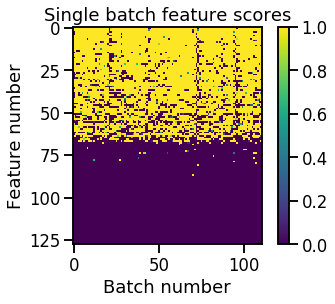

In [33]:
plt.imshow(selected_batches_throughout.T)
plt.xlabel("Batch number")
plt.ylabel("Feature number")
plt.title("Single batch feature scores")
plt.colorbar()

##  Feature selection with smooth 

In [203]:

def convex_feature_selection_by_obj_fraction_and_smooth(C, 
                                                        Q_diag, 
                                                        optimal_val, 
                                                        offset,
                                                        persist_level = 0,
                                                       P = None,
                                                       prior_vec = None):
    """
    trying to solve the convex feature selection problem of the form
    minimize f(z) = log det (C.T Q^(-1) diag(z) C )
    subject to 0.001 <= theta <= 1

    Args:
        C (np.array): num_features by num_states
        Q (np.array): 

    """

    if offset == 0:
        return np.ones((C.shape[0]))
    

    
    
    d = C.shape[0]
    ones_d = np.ones((d,1))
    theta = cp.Variable((d,1))
    
    
    if P is not np.ndarray:
        P = np.identity(C.shape[0])
        prior_vec = np.ones((d,1))
    

    Q_diag_inv =  np.linalg.inv(Q_diag)
    
    #print(Q_diag_inv)

    constraints = [theta >=0.0,  theta <= 1, 
                cp.log_det(C.T @ Q_diag_inv @cp.diag(theta) @ C) >= optimal_val - offset]

    feature_selection_objective = cp.Minimize( theta.T @ ones_d - persist_level * theta.T @ Q_diag @ prior_vec)
    feature_selection_problem = cp.Problem(feature_selection_objective, constraints)

    result = feature_selection_problem.solve()

    selected_values = theta.value.copy()

    return np.squeeze(selected_values), result

In [204]:
X_VEL_IND, Y_VEL_IND = 3,5
N_TOTAL_AVAIL_FEATS = 128

num_batches, num_sensors, num_states = C_mat.shape
offset = 1

selected_batches_throughout = []
selected_indices_throughout = []
result_all = []

selection_threshold = 0.6

active_feature_set = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)

active_feature_set_log = []

start_of_feature_selection = 10

P = np.identity(num_sensors)

for batch_i in range(num_batches):
    
    if batch_i < start_of_feature_selection:
        continue
    
    
    C_batch = C_mat[batch_i, :,(X_VEL_IND, Y_VEL_IND)].T
    Q_diag_values = Q_diag_feature[batch_i, :]
    
    Q_diag_matrix = np.diag(Q_diag_values)
    
    if batch_i  == start_of_feature_selection:
        Q_diag_inverse = np.linalg.inv(Q_diag_matrix)
        optimal_value_batches = np.log(np.linalg.det((C_batch.T @ Q_diag_inverse @ C_batch)))
        p_level = 0
        p = None
        p_vec = None
    else:
        p_level = 0.001
        
        
    selected_values, result = convex_feature_selection_by_obj_fraction_and_smooth(C_batch, 
                                                                                  Q_diag_matrix, 
                                                                                  optimal_value_batches, 
                                                                                  offset,
                                                                                 persist_level = p_level,
                                                                                 P = P, 
                                                                                 prior_vec = p_vec)
    
    # get ready for next batch
    p_vec = selected_values.copy()
    
    selected_batches_throughout.append(selected_values)
    result_all.append(result)
    
    selected_indices = np.argwhere(selected_values >= selection_threshold)
    
    active_feature_set= np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)
    active_feature_set[selected_indices] = True
    
    
    active_feature_set_log.append(active_feature_set.copy())
    
    selected_indices_throughout.append(selected_indices)
    print("finished batch_i", batch_i)
    
selected_batches_throughout = np.array(selected_batches_throughout)
selected_indices_throughout = np.array(selected_indices_throughout)
result_all = np.array(result_all)

finished batch_i 10
finished batch_i 11
finished batch_i 12
finished batch_i 13
finished batch_i 14
finished batch_i 15
finished batch_i 16
finished batch_i 17
finished batch_i 18
finished batch_i 19
finished batch_i 20
finished batch_i 21
finished batch_i 22
finished batch_i 23
finished batch_i 24
finished batch_i 25
finished batch_i 26
finished batch_i 27
finished batch_i 28
finished batch_i 29
finished batch_i 30
finished batch_i 31
finished batch_i 32
finished batch_i 33
finished batch_i 34
finished batch_i 35
finished batch_i 36
finished batch_i 37
finished batch_i 38
finished batch_i 39
finished batch_i 40
finished batch_i 41
finished batch_i 42
finished batch_i 43
finished batch_i 44
finished batch_i 45
finished batch_i 46
finished batch_i 47
finished batch_i 48
finished batch_i 49
finished batch_i 50
finished batch_i 51
finished batch_i 52
finished batch_i 53
finished batch_i 54
finished batch_i 55
finished batch_i 56
finished batch_i 57
finished batch_i 58
finished batch_i 59


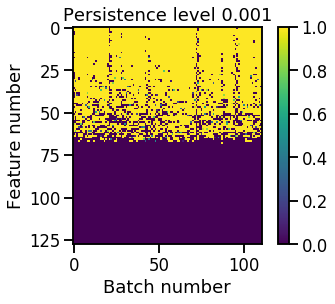

In [205]:
plt.imshow(selected_batches_throughout.T)
plt.xlabel("Batch number")
plt.ylabel("Feature number")
plt.title(f"Persistence level {p_level}")
plt.colorbar()

<class 'matplotlib.axes._subplots.AxesSubplot'>


Text(0.5, 1.0, 'Start of feature selection 10 with threshold 0.6')

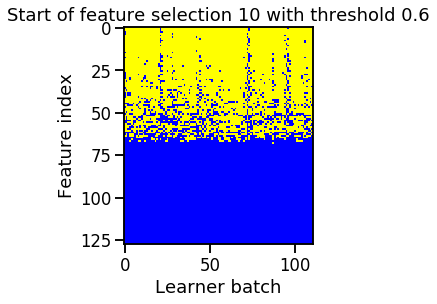

In [13]:
plot_feature_selection(active_feature_set_log)
plt.title(f"Start of feature selection {start_of_feature_selection} with threshold {selection_threshold}")

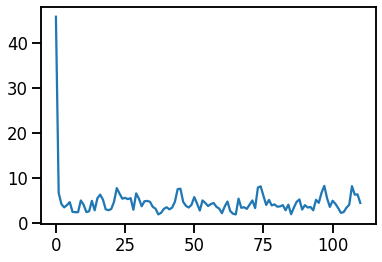

In [14]:
plt.plot(result_all)

Text(0, 0.5, 'Feature score')

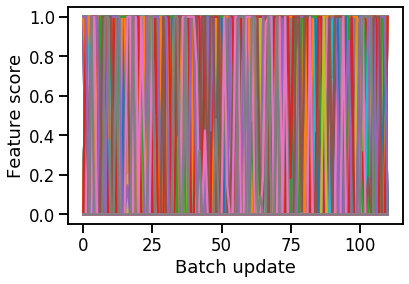

In [15]:
plt.plot(selected_batches_throughout)
plt.xlabel("Batch update")
plt.ylabel("Feature score")

##  Convex feature selection with smoothbatch on the output variables.

In [14]:
def convex_feature_selection_by_obj_fraction(C, Q_diag, optimal_val, offset):
    """
    trying to solve the convex feature selection problem of the form
    minimize f(z) = log det (C.T Q^(-1) diag(z) C )
    subject to 0.001 <= theta <= 1

    Args:
        C (np.array): num_features by num_states
        Q (np.array): 

    """

    if offset == 0:
        return np.ones((C.shape[0]))

    d = C.shape[0]
    ones_d = np.ones((d,1))
    theta = cp.Variable((d,1))

    Q_diag_inv =  np.linalg.inv(Q_diag)

    constraints = [theta >=0.0,  theta <= 1, 
                cp.log_det(C.T @ Q_diag_inv @cp.diag(theta) @ C) >= optimal_val - offset]

    feature_selection_objective = cp.Minimize( theta.T @ ones_d)
    feature_selection_problem = cp.Problem(feature_selection_objective, constraints)

    result = feature_selection_problem.solve()

    selected_values = theta.value.copy()

    return np.squeeze(selected_values), result

In [135]:
X_VEL_IND, Y_VEL_IND = 3,5
N_TOTAL_AVAIL_FEATS = 128

num_batches, num_sensors, num_states = C_mat.shape
offset = 1


# optimal values
opt_values = []

selected_batches_throughout = []
selected_indices_throughout = []
result_all = []

selection_threshold = 0.4

active_feature_set = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)

active_feature_set_log = []

start_of_feature_selection = 8

P = np.identity(num_sensors)

# let's do smooth batch setup.

rho = 0.9 # half new and half old
sb_selected_batches_throughout = []
                

for batch_i in range(num_batches):
    
    # TODO: this can be relaxed. 
    if batch_i < start_of_feature_selection:
        continue
    
    
    C_batch = C_mat[batch_i, :,(X_VEL_IND, Y_VEL_IND)].T
    Q_diag_values = Q_diag_feature[batch_i, :]
    
    Q_diag_matrix = np.diag(Q_diag_values)
    
    if batch_i  == start_of_feature_selection:
        Q_diag_inverse = np.linalg.inv(Q_diag_matrix)
        print(C_batch.shape)
        optimal_value_batches = np.log(np.linalg.det((C_batch.T @ Q_diag_inverse @ C_batch)))
        p_level = 0
    else:
        p_level = 0.0
        
    
        # save the optimal value batches
    Q_diag_inverse = np.linalg.inv(Q_diag_matrix)
    opt_values.append(np.log(np.linalg.det((C_batch.T @ Q_diag_inverse @ C_batch))))
    
    
    selected_values, result = convex_feature_selection_by_obj_fraction(C_batch, 
                                                                                  Q_diag_matrix, 
                                                                                  optimal_value_batches, 
                                                                                  offset)
    
    # save the raw decision variables
    selected_batches_throughout.append(selected_values.copy())
    result_all.append(result)
    
    # do sb mixture, right
    if len(sb_selected_batches_throughout) > 1:
        last_selected_values = sb_selected_batches_throughout[-1]
        selected_values =  (1-rho)* selected_values + rho * last_selected_values

    sb_selected_batches_throughout.append(selected_values.copy())
        
    
    # do selection if the variables exceed some threshold
    selected_indices = np.argwhere(selected_values >= selection_threshold)
    all_selected_features = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)
    all_selected_features[selected_indices] = True
    
    active_feature_set_log.append(all_selected_features.copy())
    selected_indices_throughout.append(selected_indices)
    
    
    print("finished batch_i", batch_i)

(128, 2)
finished batch_i 8
finished batch_i 9
finished batch_i 10
finished batch_i 11
finished batch_i 12
finished batch_i 13
finished batch_i 14
finished batch_i 15
finished batch_i 16
finished batch_i 17
finished batch_i 18
finished batch_i 19
finished batch_i 20
finished batch_i 21
finished batch_i 22
finished batch_i 23
finished batch_i 24
finished batch_i 25
finished batch_i 26
finished batch_i 27
finished batch_i 28
finished batch_i 29
finished batch_i 30
finished batch_i 31
finished batch_i 32
finished batch_i 33
finished batch_i 34
finished batch_i 35
finished batch_i 36
finished batch_i 37
finished batch_i 38
finished batch_i 39
finished batch_i 40
finished batch_i 41
finished batch_i 42
finished batch_i 43
finished batch_i 44
finished batch_i 45
finished batch_i 46
finished batch_i 47
finished batch_i 48
finished batch_i 49
finished batch_i 50
finished batch_i 51
finished batch_i 52
finished batch_i 53
finished batch_i 54
finished batch_i 55
finished batch_i 56
finished batc

In [136]:
# turn into np arrays
opt_values = np.array(opt_values)
sb_selected_batches_throughout = np.array(sb_selected_batches_throughout)
selected_batches_throughout = np.array(selected_batches_throughout)
selected_indices_throughout = np.array(selected_indices_throughout)
active_feature_set_log = np.array(active_feature_set_log)
result_all = np.array(result_all)


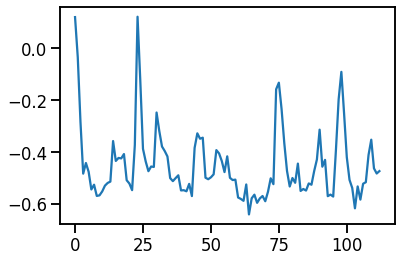

In [137]:
plt.plot(opt_values)

In [140]:
opt_values[1]

-0.034491717553648674

Text(0.5, 0, 'Batch number \n in last batch, selected 48.0928521614191 features')

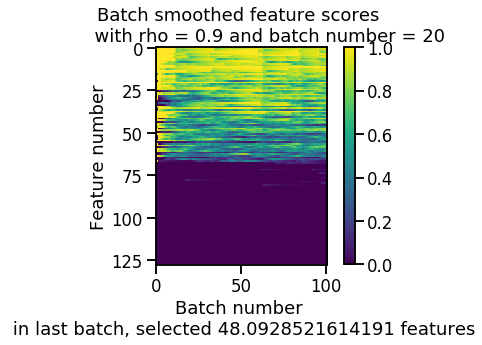

In [133]:
plt.imshow(sb_selected_batches_throughout.T)

plt.ylabel("Feature number")
plt.title(f"Batch smoothed feature scores \n\
          with rho = {rho} and batch number = {start_of_feature_selection}")
plt.colorbar()
plt.xlabel(f"Batch number \n in last batch, selected {result_all[-1]} features")

Text(0, 0.5, 'Feature selection score')

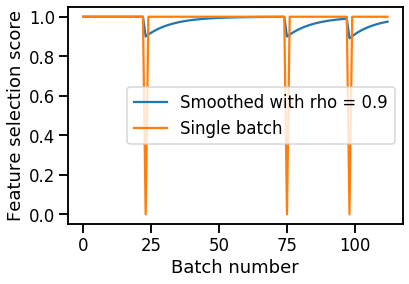

In [123]:
feature_i = 1
plt.plot(sb_selected_batches_throughout[:, feature_i])
plt.plot(selected_batches_throughout[:, feature_i])
plt.legend([f"Smoothed with rho = {rho}", "Single batch"])
plt.xlabel("Batch number")
plt.ylabel("Feature selection score")

<class 'matplotlib.axes._subplots.AxesSubplot'>


Text(0.5, 0, 'Selected 74.48094057563449')

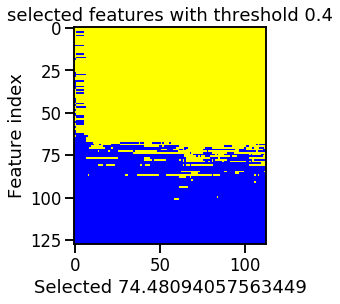

In [125]:
plot_feature_selection(active_feature_set_log)
plt.title(f"selected features with threshold {selection_threshold}")
plt.xlabel(f"Selected {result_all[-1]}")

## cast as a dual objective function

I think we are scalarize the multiobjective function
so we can have two variables

In [178]:
def convex_feature_selection_by_dual_objective(C, Q_diag, num_coef):
    """
    trying to solve the convex feature selection problem of the form
    minimize f(z) = log det (C.T Q^(-1) diag(z) C )
    subject to 0.001 <= theta <= 1

    Args:
        C (np.array): num_features by num_states
        Q (np.array): 

    """
    assert isinstance(num_coef, float) or isinstance(num_coef, int)


    d = C.shape[0]
    ones_d = np.ones((d,1))
    theta = cp.Variable((d,1))

    Q_diag_inv =  np.linalg.inv(Q_diag)

    constraints = [theta >=0.0,  theta <= 1]

    feature_selection_objective = cp.Minimize( 
        -cp.log_det(C.T @ Q_diag_inv @cp.diag(theta) @ C) + num_coef * theta.T @ ones_d)
    
    feature_selection_problem = cp.Problem(feature_selection_objective, constraints)

    result = feature_selection_problem.solve()

    selected_values = theta.value.copy()

    return np.squeeze(selected_values), result


In [185]:
# driver code that simulates the code updates

X_VEL_IND, Y_VEL_IND = 3,5
N_TOTAL_AVAIL_FEATS = 128

num_batches, num_sensors, num_states = C_mat.shape
offset = 1

num_coef_fixed = 0.1


# optimal values
opt_values = []

selected_batches_throughout = []
selected_indices_throughout = []
result_all = []

selection_threshold = 0.4

active_feature_set = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)

active_feature_set_log = []

start_of_feature_selection = 0

P = np.identity(num_sensors)

# let's do smooth batch setup.

rho = 0.9 # half new and half old
sb_selected_batches_throughout = []
                

for batch_i in range(num_batches):
    
    # TODO: this can be relaxed. 
    if batch_i < start_of_feature_selection:
        continue
    
    
    C_batch = C_mat[batch_i, :,(X_VEL_IND, Y_VEL_IND)].T
    Q_diag_values = Q_diag_feature[batch_i, :]
    
    Q_diag_matrix = np.diag(Q_diag_values)
    

    
    Q_diag_inverse = np.linalg.inv(Q_diag_matrix)
    opt_values.append(np.log(np.linalg.det((C_batch.T @ Q_diag_inverse @ C_batch))))
    
    
    selected_values, result = convex_feature_selection_by_dual_objective(C_batch, 
                                                                      Q_diag_matrix,
                                                                    num_coef_fixed)
    
    # save the raw decision variables
    selected_batches_throughout.append(selected_values.copy())
    result_all.append(result)
    
    # do sb mixture, right
    if len(sb_selected_batches_throughout) > 1:
        last_selected_values = sb_selected_batches_throughout[-1]
        selected_values =  (1-rho)* selected_values + rho * last_selected_values

    sb_selected_batches_throughout.append(selected_values.copy())
        
    
    # do selection if the variables exceed some threshold
    selected_indices = np.argwhere(selected_values >= selection_threshold)
    all_selected_features = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)
    all_selected_features[selected_indices] = True
    
    active_feature_set_log.append(all_selected_features.copy())
    selected_indices_throughout.append(selected_indices)
    
    
    print("finished batch_i", batch_i)



finished batch_i 0
finished batch_i 1
finished batch_i 2
finished batch_i 3
finished batch_i 4
finished batch_i 5
finished batch_i 6
finished batch_i 7
finished batch_i 8
finished batch_i 9
finished batch_i 10
finished batch_i 11
finished batch_i 12
finished batch_i 13
finished batch_i 14
finished batch_i 15
finished batch_i 16
finished batch_i 17
finished batch_i 18
finished batch_i 19
finished batch_i 20
finished batch_i 21
finished batch_i 22
finished batch_i 23
finished batch_i 24
finished batch_i 25
finished batch_i 26
finished batch_i 27
finished batch_i 28
finished batch_i 29
finished batch_i 30
finished batch_i 31
finished batch_i 32
finished batch_i 33
finished batch_i 34
finished batch_i 35
finished batch_i 36
finished batch_i 37
finished batch_i 38
finished batch_i 39
finished batch_i 40
finished batch_i 41
finished batch_i 42
finished batch_i 43
finished batch_i 44
finished batch_i 45
finished batch_i 46
finished batch_i 47
finished batch_i 48
finished batch_i 49
finished b

In [186]:
# turn into np arrays
sb_selected_batches_throughout = np.array(sb_selected_batches_throughout)
selected_batches_throughout = np.array(selected_batches_throughout)
selected_indices_throughout = np.array(selected_indices_throughout)
active_feature_set_log = np.array(active_feature_set_log)
result_all = np.array(result_all)


Text(0.5, 0, 'Batch number')

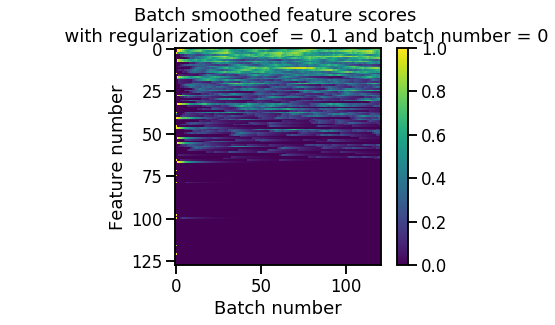

In [187]:
plt.imshow(sb_selected_batches_throughout.T)

plt.ylabel("Feature number")
plt.title(f"Batch smoothed feature scores \n\
          with regularization coef  = {num_coef_fixed} and batch number = {start_of_feature_selection}")
plt.colorbar()
plt.xlabel(f"Batch number")

Text(0, 0.5, 'Feature selection score')

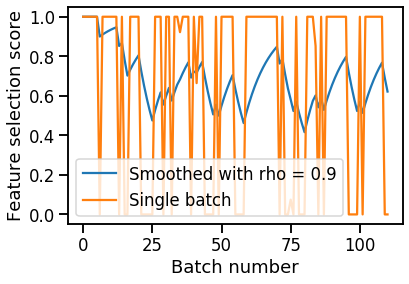

In [165]:
feature_i = 1
plt.plot(sb_selected_batches_throughout[:, feature_i])
plt.plot(selected_batches_throughout[:, feature_i])
plt.legend([f"Smoothed with rho = {rho}", "Single batch"])
plt.xlabel("Batch number")
plt.ylabel("Feature selection score")

## Adaptively shaping the feature selection process

In [194]:
# driver code that simulates the code updates

X_VEL_IND, Y_VEL_IND = 3,5
N_TOTAL_AVAIL_FEATS = 128

num_batches, num_sensors, num_states = C_mat.shape
offset = 1

num_coef_fixed = 0.1


# optimal values
opt_values = []

selected_batches_throughout = []
selected_indices_throughout = []
result_all = []

selection_threshold = 0.4

active_feature_set = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)

active_feature_set_log = []

start_of_feature_selection = 0

P = np.identity(num_sensors)

# let's do smooth batch setup.

rho = 0.9 # half new and half old
sb_selected_batches_throughout = []

start_reg = 0.01
stop_reg = 0.5
adaptive_reg_values = np.linspace(start_reg, stop_reg, num_batches)
                

for batch_i in range(num_batches):
    
    # choose reg value
    reg_value = adaptive_reg_values[batch_i]
    
    
    C_batch = C_mat[batch_i, :,(X_VEL_IND, Y_VEL_IND)].T
    Q_diag_values = Q_diag_feature[batch_i, :]
    
    Q_diag_matrix = np.diag(Q_diag_values)
    

    
    Q_diag_inverse = np.linalg.inv(Q_diag_matrix)
    opt_values.append(np.log(np.linalg.det((C_batch.T @ Q_diag_inverse @ C_batch))))
    
    
    selected_values, result = convex_feature_selection_by_dual_objective(C_batch, 
                                                                      Q_diag_matrix,
                                                                        reg_value)
    
    # save the raw decision variables
    selected_batches_throughout.append(selected_values.copy())
    result_all.append(result)
    
    # do sb mixture, right
    if len(sb_selected_batches_throughout) > 1:
        last_selected_values = sb_selected_batches_throughout[-1]
        selected_values =  (1-rho)* selected_values + rho * last_selected_values

    sb_selected_batches_throughout.append(selected_values.copy())
        
    
    # do selection if the variables exceed some threshold
    selected_indices = np.argwhere(selected_values >= selection_threshold)
    all_selected_features = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)
    all_selected_features[selected_indices] = True
    
    active_feature_set_log.append(all_selected_features.copy())
    selected_indices_throughout.append(selected_indices)
    
    
    print("finished batch_i", batch_i)

finished batch_i 0
finished batch_i 1
finished batch_i 2
finished batch_i 3
finished batch_i 4
finished batch_i 5
finished batch_i 6
finished batch_i 7
finished batch_i 8
finished batch_i 9
finished batch_i 10
finished batch_i 11
finished batch_i 12
finished batch_i 13
finished batch_i 14
finished batch_i 15
finished batch_i 16
finished batch_i 17
finished batch_i 18
finished batch_i 19
finished batch_i 20
finished batch_i 21
finished batch_i 22
finished batch_i 23
finished batch_i 24
finished batch_i 25
finished batch_i 26
finished batch_i 27
finished batch_i 28
finished batch_i 29
finished batch_i 30
finished batch_i 31
finished batch_i 32
finished batch_i 33
finished batch_i 34
finished batch_i 35
finished batch_i 36
finished batch_i 37
finished batch_i 38
finished batch_i 39
finished batch_i 40
finished batch_i 41
finished batch_i 42
finished batch_i 43
finished batch_i 44
finished batch_i 45
finished batch_i 46
finished batch_i 47
finished batch_i 48
finished batch_i 49
finished b

In [195]:
# turn into np arrays
sb_selected_batches_throughout = np.array(sb_selected_batches_throughout)
selected_batches_throughout = np.array(selected_batches_throughout)
selected_indices_throughout = np.array(selected_indices_throughout)
active_feature_set_log = np.array(active_feature_set_log)
result_all = np.array(result_all)


Text(0, 0.5, 'Sparsity regularization coef.')

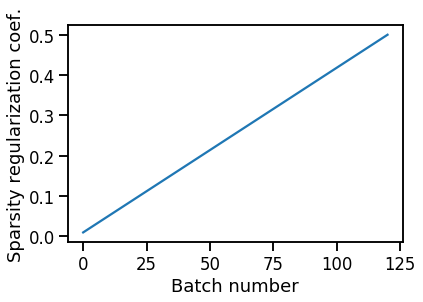

In [201]:
plt.plot(adaptive_reg_values)
plt.xlabel("Batch number")
plt.ylabel("Sparsity regularization coef.")

Text(0.5, 0, 'Batch number')

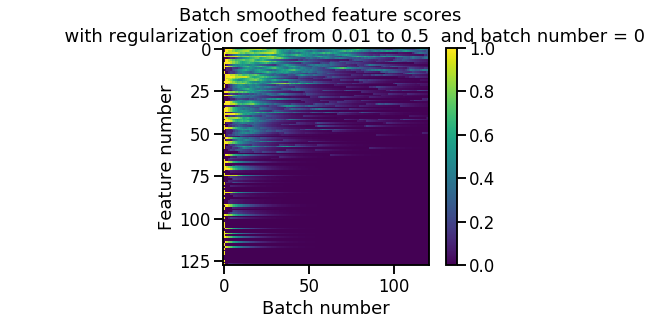

In [202]:
plt.imshow(sb_selected_batches_throughout.T)

plt.ylabel("Feature number")
plt.title(f"Batch smoothed feature scores  \n\
          with regularization coef from {start_reg} to {stop_reg}  and batch number = {start_of_feature_selection}")
plt.colorbar()
plt.xlabel(f"Batch number")

## incorporate smooth objective

In [15]:
def convex_feature_selection_by_smooth_obj(C, 
                                           Q_diag, 
                                           optimal_val, 
                                           offset,  
                                           prior_matrix):
    """
    trying to solve the convex feature selection problem of the form
    minimize f(z) = log det (C.T Q^(-1) diag(z) C )
    subject to 0.001 <= theta <= 1

    Args:
        C (np.array): num_features by num_states
        Q (np.array): 

    """

    if offset == 0:
        return np.ones((C.shape[0]))

    d = C.shape[0]
    num_prior_columns = prior_matrix.shape[1]
    
    ones_d = np.ones((d,1))
    ones_prior = np.ones((num_prior_columns,1))
    theta = cp.Variable((d,1))

    Q_diag_inv =  np.linalg.inv(Q_diag)

    constraints = [theta >=0.0,  theta <= 1, 
                cp.log_det(C.T @ Q_diag_inv @cp.diag(theta) @ C) >= optimal_val - offset]

    feature_selection_objective = cp.Minimize( theta.T @ ones_d - theta.T @ prior_matrix @ ones_prior )
    feature_selection_problem = cp.Problem(feature_selection_objective, constraints)

    result = feature_selection_problem.solve()

    selected_values = theta.value.copy()
    
    return np.squeeze(selected_values), result

In [64]:
import collections

X_VEL_IND, Y_VEL_IND = 3,5
N_TOTAL_AVAIL_FEATS = 128

num_batches, num_sensors, num_states = C_mat.shape
offset = 1

selected_batches_throughout = []
selected_indices_throughout = []
result_all = []

selection_threshold = 0.5

active_feature_set = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)

active_feature_set_log = []

start_of_feature_selection = 10

P = np.identity(num_sensors)

K = 5
curr_prior_deque = collections.deque()
alpha = 0.4

next_disc_memory = np.empty((N_TOTAL_AVAIL_FEATS, 0))


for batch_i in range(num_batches):
    
    if batch_i < start_of_feature_selection:
        continue
    
    
    C_batch = C_mat[batch_i, :,(X_VEL_IND, Y_VEL_IND)].T
    Q_diag_values = Q_diag_feature[batch_i, :]
    
    Q_diag_matrix = np.diag(Q_diag_values)
    
    if batch_i  == start_of_feature_selection:
        Q_diag_inverse = np.linalg.inv(Q_diag_matrix)
        print(C_batch.shape)
        optimal_value_batches = np.log(np.linalg.det((C_batch.T @ Q_diag_inverse @ C_batch)))

        
    # we use different obj functions for the dual objectives
    print(next_disc_memory.shape)
    if next_disc_memory.shape[1] >=  K:
        selected_values, result = convex_feature_selection_by_smooth_obj(C_batch, 
                                                                  Q_diag_matrix, 
                                                                  optimal_value_batches, 
                                                                  offset,
                                                                   next_disc_memory)
        #print("doing smooth obj", batch_i)

    else:
        selected_values, result = convex_feature_selection_by_obj_fraction(C_batch, 
                                                                  Q_diag_matrix, 
                                                                  optimal_value_batches, 
                                                                  offset)
    
    curr_prior_deque.appendleft(selected_values.copy())
    # check if the prior_matrix
    if len(curr_prior_deque) > K:
        curr_prior_deque.pop()

    next_disc_memory = np.array(curr_prior_deque).T
    next_disc_memory = alpha * next_disc_memory
    
    selected_batches_throughout.append(selected_values)
    result_all.append(result)
    
    # 
    selected_indices = np.argwhere(selected_values >= selection_threshold)
    all_selected_features = np.full(N_TOTAL_AVAIL_FEATS, False, dtype = bool)
    all_selected_features[selected_indices] = True
    
    active_feature_set_log.append(active_feature_set.copy())
    
    selected_indices_throughout.append(selected_indices)
    print("finished batch_i", batch_i)

(128, 2)
(128, 0)
finished batch_i 10
(128, 1)
finished batch_i 11
(128, 2)
finished batch_i 12
(128, 3)
finished batch_i 13
(128, 4)
finished batch_i 14
(128, 5)
finished batch_i 15
(128, 5)
finished batch_i 16
(128, 5)
finished batch_i 17
(128, 5)
finished batch_i 18
(128, 5)
finished batch_i 19
(128, 5)
finished batch_i 20
(128, 5)
finished batch_i 21
(128, 5)
finished batch_i 22
(128, 5)
finished batch_i 23
(128, 5)
finished batch_i 24
(128, 5)
finished batch_i 25
(128, 5)
finished batch_i 26
(128, 5)
finished batch_i 27
(128, 5)
finished batch_i 28
(128, 5)
finished batch_i 29
(128, 5)
finished batch_i 30
(128, 5)
finished batch_i 31
(128, 5)
finished batch_i 32
(128, 5)
finished batch_i 33
(128, 5)
finished batch_i 34
(128, 5)
finished batch_i 35
(128, 5)
finished batch_i 36
(128, 5)
finished batch_i 37
(128, 5)
finished batch_i 38
(128, 5)
finished batch_i 39
(128, 5)
finished batch_i 40
(128, 5)
finished batch_i 41
(128, 5)
finished batch_i 42
(128, 5)
finished batch_i 43
(128,

In [65]:
# turn into np arrays
selected_batches_throughout = np.array(selected_batches_throughout)
selected_indices_throughout = np.array(selected_indices_throughout)
active_feature_set_log = np.array(active_feature_set_log)
result_all = np.array(result_all)


Text(0.5, 0, 'Batch number')

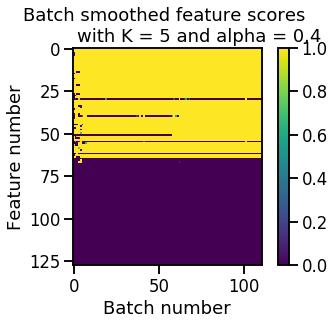

In [66]:
plt.imshow(selected_batches_throughout.T)

plt.ylabel("Feature number")
plt.title(f"Batch smoothed feature scores \n\
            with K = {K} and alpha = {alpha} ")
plt.colorbar()
plt.xlabel(f"Batch number")

Text(0.5, 1.0, ' Optimization result over time')

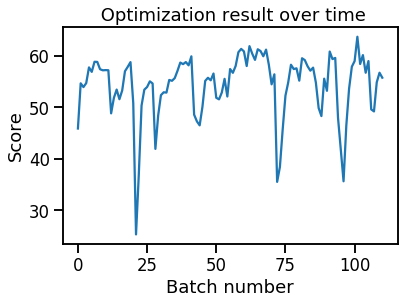

In [56]:
plt.plot(result_all)
plt.xlabel("Batch number")
plt.ylabel("Score")
plt.title(" Optimization result over time")

# Behaviour  analyses

## Trajectory analysis

In [ ]:
def calculate_traj_length(trajectories):
    """
    given a list of trajectories, calculate each trajectory's length
    
    args:
        trajectories[np.ndarray]: number of data points by number of dims
    """
    traj_length = np.empty((len(trajectories)))
    
    for i,t in enumerate(trajectories):
        delta = np.diff(t, axis = 0)
        
        
        delta_length = delta**2
        
        
        delta_sum = np.sum(delta_length, axis = 1) ** (1/2)
        
        delta_sum = np.sum(delta_sum)
        
        traj_length[i] = delta_sum
        
    return traj_length
        
        

def test_calculate_traj_length():
    
    
    #test a line segment length
    cursor_trajectory = np.arange(0,1, 0.1).reshape(-1,1)
    expected_trajectory_length = np.array([0.9])
    calculated_trajectory_length = calculate_traj_length([cursor_trajectory])
    
    np.testing.assert_array_equal(expected_trajectory_length, calculated_trajectory_length)
    
    
test_calculate_traj_length()    

In [ ]:


cursor_length = [calculate_traj_length(t) for t in cursor_trajectories_list]

cursor_length_array = np.asarray(cursor_length).reshape(3, N_RUNS)

colors =  ['b','r', 'y']

print(len(cursor_length))
for t,c in zip(cursor_length_array, colors):
    print(t.shape)
    for l in t:
        plt.plot(l, color = c, alpha = 0.5)

plt.legend(['Full set','Iterative addition', 'Constant subset'])
plt.ylabel('Trial Length (cm)')

plt.xlabel('Trial #')

## Variance analysis

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

## decoder

In [ ]:
exp_data_all[0]['feature_selection'].keys()

In [ ]:
from afs_plotting import plot_prefered_directions

C_mat = exp_data_all[2]['feature_selection']['C_mat']

print(C_mat.shape)



fig, ax = plt.subplots(1,2)

plot_prefered_directions(C_mat[0], ax = ax[0])
plot_prefered_directions(C_mat[-1], ax = ax[1])

In [ ]:
from afs_plotting import plot_prefered_directions

def plot_all_initial_C_mat(exp_data_all, selected_neuron = 'all',debug = True):
    
    """
    just compare initial C mat with the last C_mat
    """
    
    N_EXP = len(exp_data_all)
    
    fig, ax = plt.subplots(2, N_EXP)
    
    for i in range(N_EXP):
        C_mat = exp_data_all[i]['feature_selection']['C_mat']
        plot_prefered_directions(C_mat[0][no_noise_neuron_ind,:], ax = ax[0,i])
        plot_prefered_directions(C_mat[-1][no_noise_neuron_ind,:], ax = ax[1,i])
        

plot_all_initial_C_mat(exp_data_all)


## Decoder compared to the encoder



In [ ]:
exp_data_all[0].keys()

In [ ]:
exp_data_all.shape

In [38]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

active_angles_list = list()

least_num_updates = 180

for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['C_mat']
    
    angles_hist = calc_cosine_to_target_matrix(dec_directions, enc_directions)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    active_angles_list.append(active_angles[:least_num_updates])


KeyError: 'C_mat'

(3, 0)


<Figure size 432x288 with 0 Axes>

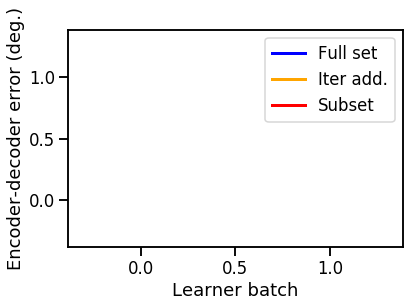

In [15]:

active_angles_list = np.array(active_angles_list) 


active_angles_list_reshape = active_angles_list.reshape((3,N_RUNS,-1))

active_angles_std = np.std(active_angles_list_reshape, axis = 1)
active_angles_mean =  np.mean(active_angles_list_reshape, axis = 1)


plt.figure()

batch_num = np.arange(active_angles_mean.shape[1])


colors = ['blue', 'orange', 'red'] 

print(active_angles_mean.shape)

fig_C, ax_C = plt.subplots()



for i,c in enumerate(colors):

    plt.plot(active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)

plt.xlabel('Learner batch')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

## batch update 

In [ ]:
exp_data_all

In [ ]:
len(exp_data_all)

In [17]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

def train_C_mat_on_batch_data(intended_kin, spike_counts_batch):

    C_hat_list = list()
    
    num_times =  intended_kin.shape[0]
    
    for i  in range(num_times):

        k = intended_kin[i, :,:]
        s = spike_counts_batch[i,:,:]

        C,Q = KalmanFilter.MLE_obs_model(k, s, include_offset=False, drives_obs=[3,5])

        C_hat_list.append(C)



    C_hat_list = np.array(C_hat_list)
    
    return C_hat_list
    

In [18]:
import sympy as sp

clda_log = exp_data_all[0]['bmi3d_clda']
intended_kin = clda_log['intended_kin']
spike_counts_batch = clda_log['spike_counts_batch']
kf_C = clda_log['kf_C']

c_hat_list = train_C_mat_on_batch_data(intended_kin, spike_counts_batch)

NameError: name 'KalmanFilter' is not defined

In [ ]:
c_hat_angles = calc_cosine_to_target_matrix(c_hat_list)

## compare to lasso regularization

In [19]:
from sklearn.linear_model import Lasso, LinearRegression

alpha = 10
max_iteration = 10000

lasso_model = Lasso(alpha, max_iter = max_iteration)
linear_reg_model = LinearRegression()

In [20]:
drive_obs = [3,5]

intended_kin_one_batch = intended_kin[0,drive_obs,:]
spike_counts_one_batch = spike_counts_batch[0,:,:]

lasso_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T )

Lasso(alpha=10, max_iter=10000)

In [21]:
linear_reg_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T)

LinearRegression()

In [22]:
# get a series of alphas 

alpha_series = [0, 1, 10, 100] #get a series of alphas

alpha_weights_scan = []

for a in alpha_series:
    lasso_model.set_params(alpha = a)
    lasso_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T)
    
    alpha_weights_scan.append(lasso_model.coef_.copy())
    
    print(f'finished alpha = {a}')

alpha_weights = np.array(alpha_weights_scan)

finished alpha = 0
finished alpha = 1
finished alpha = 10
finished alpha = 100


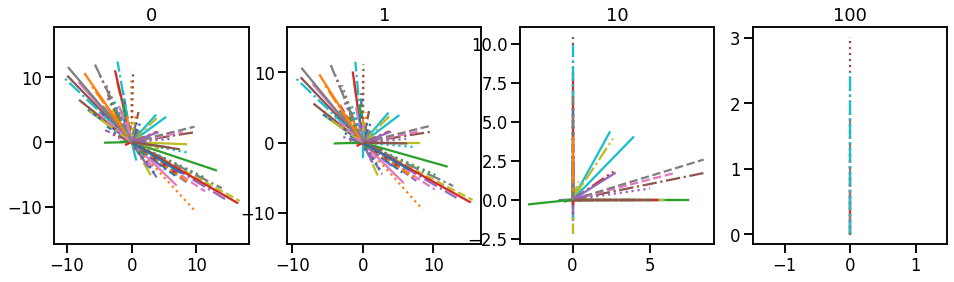

In [23]:
from afs_plotting import plot_prefered_directions

fig, ax = plt.subplots(1, len(alpha_series), figsize = (4 * len(alpha_series), 4))

for a,w,ax_i in zip(alpha_series, alpha_weights_scan, ax):
    plot_prefered_directions(w, ax = ax_i)
    ax_i.set_title(a)


In [24]:
alpha_weights_norm = np.linalg.norm(alpha_weights, axis = 2)

Text(0, 0.5, 'Weight norm')

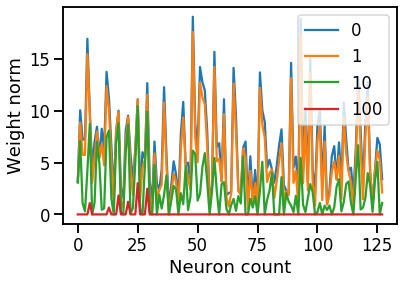

In [25]:
plt.plot(alpha_weights_norm.T)
plt.legend(alpha_series)
plt.xlabel('Neuron count')
plt.ylabel('Weight norm')

In [26]:
# we can then look at lasso path to figure out the smooth coefficients 

from sklearn.linear_model import lasso_path 

eps = 5e-3  # the smaller it is the longer is the path
print("Computing regularization path using the lasso...")
X = intended_kin_one_batch.T
y = spike_counts_one_batch.T
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

print(alphas_lasso.shape,min(alphas_lasso), max(alphas_lasso))
print('shape of coefs_lasso', coefs_lasso.shape)

Computing regularization path using the lasso...
(100,) 55.02534879416641 11005.069758833279
shape of coefs_lasso (128, 2, 100)


(100,)

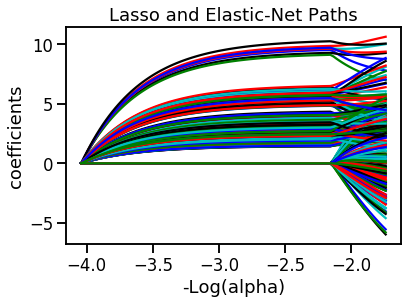

In [27]:

from itertools import cycle

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l.T, c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.axis("tight")

neg_log_alphas_lasso.shape

(128, 100)


(100,)

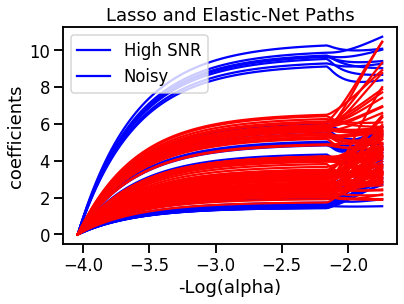

In [28]:
from numpy.linalg import norm

coefs_lasso_norm = norm(coefs_lasso, axis = 1)
print(coefs_lasso_norm.shape)



from itertools import cycle


num_high_snr = 32
num_noise = 96

plt.figure(1)
colors = ['b'] * num_high_snr + ['r'] * num_noise
neg_log_alphas_lasso = -np.log10(alphas_lasso)

for l1_coef, c in zip(coefs_lasso_norm, colors):

    l1 = plt.plot(neg_log_alphas_lasso, l1_coef, c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.axis("tight")
plt.legend(['High SNR', 'Noisy'])
neg_log_alphas_lasso.shape

there are two issue

In [39]:
lasso_hist = feature_selection_data['lasso_hist']

print(lasso_hist.shape)

(240, 2, 128)


##  examine the lasso_hist coefficients.
the main problem is that it does not converge on the fly
it does not converge,  becasue we did not use the right indices to train. 
this can still happen in real time.

this highlights the issue in real time,  we just cannot randomly trained a lasso regression. 


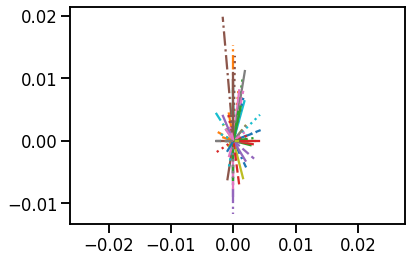

In [41]:
num_batch = 0
plot_prefered_directions(lasso_hist[num_batch, :, :].T)

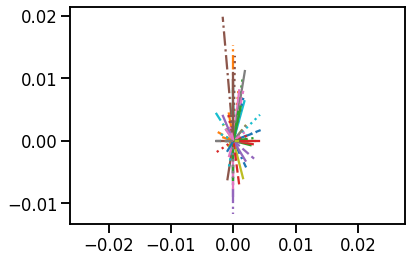

In [43]:
num = -1
plot_prefered_directions(lasso_hist[num_batch,:,:].T)

a quick comparision between the two shows that the observation matrix does not change. 
which basically makes sense, in the sense that 

## looking at K matrix

In [ ]:
NUM_EXP = 3
GLOBAL_FIGURE_VERTICAL_SIZE  = 4

figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))
exp_data_all_reshaped = exp_data_all.reshape(3, N_RUNS)


#compare the K matrix before the exp
for i in range(NUM_EXP):
    K_mat = exp_data_all_reshaped[0,i]['feature_selection']['K_mat']
    K = K_mat[1].T

    plot_prefered_directions(K, ax  = axes_k_matrix[0, i], plot_states = [0,2])
    axes_k_matrix[0, i].set_title(exp_conds[i])

#compare to the matrix after the exp
for i in range(3):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    
    K = K_mat[-1].T
    plot_prefered_directions(K, ax  = axes_k_matrix[1, i], plot_states = [0,2])
    axes_k_matrix[1,i].set_title(exp_conds[i])
figure_k_matrix.tight_layout()

In [ ]:



def plot_state_bar(K:np.ndarray, ax =  None, fig = fig, state_names = None):
    """
    K [np.array]: a state variable that records the state
    """
    
    num_state, num_var = K.shape
    
    if num_state >= num_var: print(f'Number of states {num_state} is greater than the {num_var} \n is this intended?')
        
    if ax is None: fig, ax = plt.subplots(2, 3, figsize = (12, 8),sharex =  True)
        
    var_pos = np.arange(num_var)
    
    for i in range(3):
        ax[0, i].bar(var_pos, K[i,:])
        ax[1,i].bar(var_pos, K[i + 3,:])
        
        
        
    fig.tight_layout()
    
    return ax


fig, ax = plt.subplots(2,3, figsize = (12,8))


for i in range(len(exp_data_all)):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    K = K_mat[-1]

    plot_state_bar(abs(K), ax = ax, fig = fig)

In [ ]:
active_feat_set = feature_selection_data['feat_set']
active_feat_set_last = active_feat_set[0]
active_angles_list = list()

least_num_updates = 180

for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['K_mat']

    dec_directions = np.moveaxis(dec_directions, 2,1)   
    

    angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                               enc_directions)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    

    active_angles_list.append(active_angles[:least_num_updates])


In [ ]:

active_angles_list = np.array(active_angles_list)
active_angles_list = active_angles_list.reshape((3,N_RUNS,-1))

active_angles_mean = np.mean(active_angles_list, axis = 1)
active_angles_std = np.std(active_angles_list, axis = 1)

colors = ['blue', 'orange', 'red'] 

print(active_angles_mean.shape)

fig_C, ax_C = plt.subplots()



for i,c in enumerate(colors):

    plt.plot(active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)


plt.xlabel('Learner batch number')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

In [ ]:


fig_C, ax_C = plt.subplots()


colors = ['blue', 'orange'] 

batch_num = np.arange(least_num_updates) * 10

print(active_angles_mean.shape)

for i,c in enumerate(colors):

    plt.plot(batch_num, active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)

plt.title('Initial training on subset enables faster decoder convergence')
plt.xlabel('Training time (s)')
plt.ylabel('Encoder-decoder error (deg.)', fontsize = 14)
plt.legend(['Full set', 'Iter add.'])

In [ ]:
# examine the features after the first update.

def find_K_gain(index:int, update_period: float, fps = 60):
    """
    find the latest Kalman gain
    """
    update_frame_count = int(update_period * fps)
    
    return int(index // update_frame_count)
    
def test_find_K_gain():
    
    assert 0 == find_K_gain(598, 10, 60)
    assert 1 == find_K_gain(1198, 10, 60)

test_find_K_gain()

In [ ]:
update_time = 600

spike_counts = exp_data_all[0]['bmi3d_task']['spike_counts']
spike_counts = np.squeeze(spike_counts)

spike_counts_single_time = spike_counts[update_time, :]

target_state  = exp_data_all[0]['bmi3d_task']['target_state']
target_state_time = target_state[update_time, :]


num_K = find_K_gain(update_time, update_period = 10)
K_mat_time = K_mat[num_K]

feature_state_update = K_mat_time @  np.diag(spike_counts_single_time)


target_state_time_rep = np.tile(target_state_time, len(spike_counts_single_time))


useful_update = feature_state_update * target_state_time_rep
useful_update = np.sum(useful_update, axis = 0)


plt.plot(useful_update)


In [ ]:
intended_kin = exp_data_all[0]['bmi3d_clda']['intended_kin']

spike_counts_batch = exp_data_all[0]['bmi3d_clda']['spike_counts_batch']
spike_counts_batch =  np.swapaxes(spike_counts_batch, 2, 1)

intended_kin = np.swapaxes(intended_kin, 2, 1)

spike_counts_batch.shape

In [ ]:
print(intended_kin.shape)

intended_kin_one = intended_kin[1, 1, :]
print(intended_kin_one)

## Q mat

In [ ]:
feature_selection_data.keys()

In [ ]:
fig_Q, axes_Q = plt.subplots(1,2, sharey = True)

num_noises = 1

from afs_plotting import get_cmap
import matplotlib as mpl

cmap_q = get_cmap(num_noises)

cmap_q_1 = get_cmap(num_noises, mpl.cm.Oranges)

cmap_q_2 = get_cmap(num_noises, mpl.cm.Reds)

for i in range(num_noises):
    
    for j in range(3):


        Q_list = np.array(exp_data_all[j]["feature_selection"]['Q_diag'])



        Q_diag_no_noise = np.mean(Q_list[:, no_noise_neuron_ind], axis = 1)

        Q_diag_noise = np.mean(Q_list[:, noise_neuron_ind], axis = 1)



        axes_Q[0].plot(Q_diag_noise)

        axes_Q[1].plot(Q_diag_no_noise)

    

axes_Q[0].set_xlabel('Time (s)')

axes_Q[1].set_xlabel('Time (s)')



axes_Q[0].set_title('Low SNR neurons')

axes_Q[1].set_title('High SNR neurons')



# Feature analysis

In [ ]:
decoder_state = exp_data_all[0]['bmi3d_task']['decoder_state']
target_state = exp_data_all[0]['bmi3d_task']['target_state']
spike_counts = exp_data_all[0]['bmi3d_task']['spike_counts']


print(decoder_state.shape)
print(target_state.shape)
print(spike_counts.shape)

spike_counts = exp_data_all[0]['bmi3d_task'].dtype

In [ ]:
exp_data_all[0]['bmi3d_task'].dtype

In [ ]:
exp_data_all[0]['feature_selection']['K_mat'].shape

In [ ]:
exp_data_all[0]['bmi3d_task']['update_bmi']

In [ ]:
np.argwhere((exp_data_all[0]['bmi3d_task']['update_bmi']))

## examine used C mat

In [ ]:
GLOBAL_FIGURE_VERTICAL_SIZE  =  10

fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list

for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C = enc_directions)


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
#axes_compr_means.set_title('Means of the high SNR weight trajectory')

## debugging

In [ ]:
np.log(np.linalg.det((C.T @ Q_diag_inv @ np.diag(theta.value[:,0])@ C)))